# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss_history = []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        # <your code>
        return (1 / (1 + np.exp(-(np.dot(X, weights)))))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        # <your code>
        return np.mean(np.log(1+np.exp(-(x@weights)*y))) + np.linalg.norm(weights, 2)/(2*self.C)
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization

        for i in range(self.max_iter):
            self.loss_history.append(self.get_loss(X_ext,self.weights_,y))
            delta_ = 0
            for j in range(y.shape[0]):
                delta_ += y[j]*X_ext[j]*(1-1/(1+np.exp((-self.weights_@X_ext[j])*y[j])))
            delta = self.weights_/self.C - delta_/y.shape[0]
            self.weights_ -= self.eta * delta
            if np.linalg.norm(delta, 2) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        return np.where(self.predict_proba(X)<0.5, -1, 1)

In [5]:
from sklearn import datasets
from sklearn import metrics

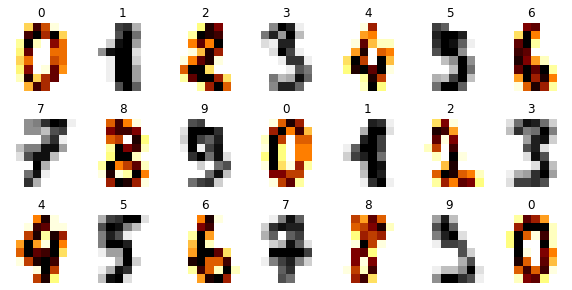

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [11]:
lr_clf.fit(X_train, y_train)

In [12]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [13]:
model = CustomLogisticRegression()

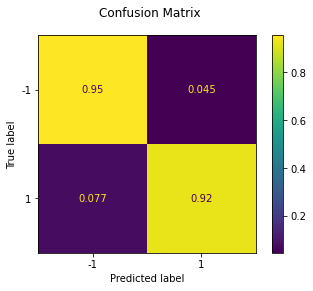

In [14]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [15]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [16]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

<AxesSubplot:xlabel='Шаг', ylabel='Ошибка'>

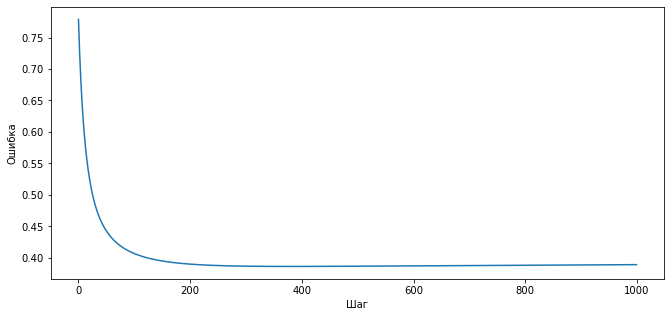

In [17]:
## your code
plt.figure(figsize=(11,5))
plt.xlabel('Шаг')
plt.ylabel('Ошибка')
sns.lineplot(data=model.loss_history)

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

In [18]:
## your code
rates = [0.0001, 0.001, 0.005, 0.01, 0.03]
losses = []
for i in rates:
    model = CustomLogisticRegression(eta=i)
    model.fit(X_train, y_train)
    losses.append(model.loss_history)

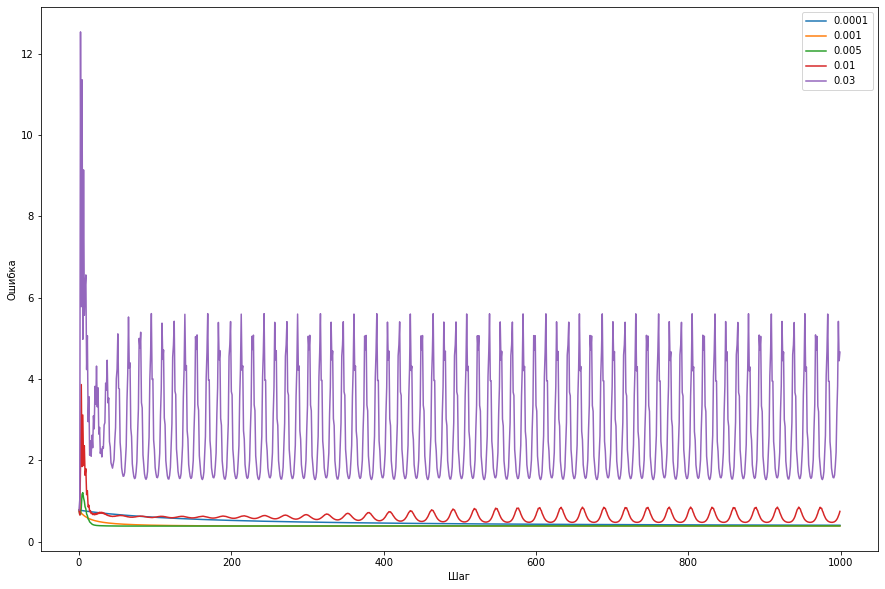

In [19]:
plt.figure(figsize=(15,10))
plt.xlabel('Шаг')
plt.ylabel('Ошибка')
for i in range(len(losses)):
    sns.lineplot(data=losses[i], label=rates[i])

При большой скорости обучения падает сходимость, при низкой - требуется больше итераций

**(0.5 points)** Try different regularization parameter values and compare the model quality.

C:\Users\alex_\AppData\Local\Temp/ipykernel_4740/1857530037.py:38: RuntimeWarning: divide by zero encountered in double_scalars
  return np.mean(np.log(1+np.exp(-(x@weights)*y))) + np.linalg.norm(weights, 2)/(2*self.C)
C:\Users\alex_\AppData\Local\Temp/ipykernel_4740/1857530037.py:62: RuntimeWarning: divide by zero encountered in true_divide
  delta = self.weights_/self.C - delta_/y.shape[0]
C:\Users\alex_\AppData\Local\Temp/ipykernel_4740/1857530037.py:38: RuntimeWarning: invalid value encountered in matmul
  return np.mean(np.log(1+np.exp(-(x@weights)*y))) + np.linalg.norm(weights, 2)/(2*self.C)
C:\Users\alex_\AppData\Local\Temp/ipykernel_4740/1857530037.py:61: RuntimeWarning: invalid value encountered in matmul
  delta_ += y[j]*X_ext[j]*(1-1/(1+np.exp((-self.weights_@X_ext[j])*y[j])))


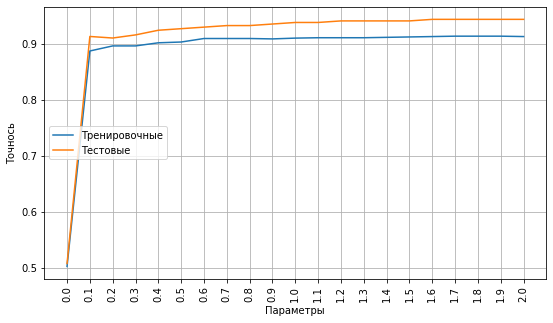

In [21]:
## your code
C = np.linspace(0, 2, 1+20)
models = []
for i in C:
    model = CustomLogisticRegression(C=i)
    model.fit(X_train, y_train)
    models.append(model)
    
metric_train, metric_valid = [], []
for i in range(len(C)):
    train_acc, test_acc = metrics.accuracy_score(y_pred=models[i].predict(X_train), y_true=y_train), metrics.accuracy_score(y_pred=models[i].predict(X_test), y_true=y_test)
    metric_train.append(train_acc)
    metric_valid.append(test_acc)
    
plt.figure(figsize=(9, 5))
plt.plot(np.linspace(0, 2, 1+20), metric_train, label='Train')
plt.plot(np.linspace(0, 2, 1+20), metric_valid, color='C1', label='Test')
plt.xlabel("Параметры")
plt.ylabel("Точнось")
plt.grid(True)
plt.xticks(np.linspace(0, 2, 1+20), rotation='vertical')
plt.legend(loc='center left')            
plt.show()

При повышении C качество модели увеличивается

**(0.5 points)** Compare zero initialization and random initialization. 

<AxesSubplot:xlabel='Шак', ylabel='Ошибка'>

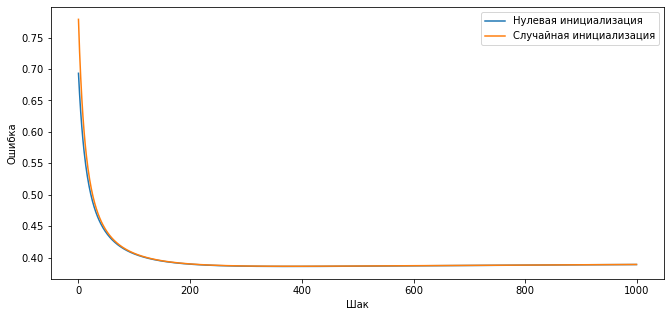

In [22]:
## your code
model_zeros = CustomLogisticRegression(zero_init=True)
model_random = CustomLogisticRegression()
model_zeros.fit(X_train, y_train)
model_random.fit(X_train, y_train)

plt.figure(figsize=(11,5))
plt.xlabel('Шак')
plt.ylabel('Ошибка')
sns.lineplot(data=model_zeros.loss_history, label='Нулевая инициализация')
sns.lineplot(data=model_random.loss_history, label='Случайная инициализация')

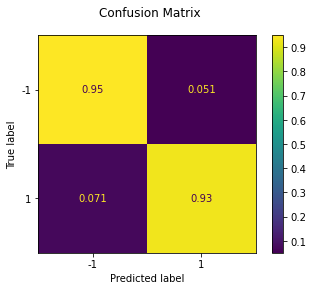

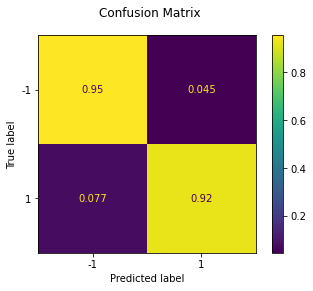

In [23]:
disp = metrics.plot_confusion_matrix(model_zeros, X_test, y_test, normalize='true')
disp.figure_.suptitle("Confusion Matrix")
plt.show()
train_acc_zeros, test_acc_zeros = metrics.accuracy_score(y_pred=model_zeros.predict(X_train), y_true=y_train),metrics.accuracy_score(y_pred=model_zeros.predict(X_test), y_true=y_test)
disp = metrics.plot_confusion_matrix(model_random, X_test, y_test, normalize='true')
disp.figure_.suptitle("Confusion Matrix")
plt.show()
train_acc, test_acc = metrics.accuracy_score(y_pred=model_random.predict(X_train), y_true=y_train),metrics.accuracy_score(y_pred=model_random.predict(X_test), y_true=y_test)

Здесь нету особой разницы между инициализациями весов, но в других задачах это может влиять на скорость обучения

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [24]:
PATH = "./data/"

In [30]:
data = pd.read_csv(os.path.join("./data/", 'titanic', 'train.csv')).set_index('PassengerId')

In [26]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

Количество женщин\мужчин:
Sex
male      56114
female    43886
dtype: int64
Количество Живых\мертвых:
Survived
0    57226
1    42774
dtype: int64


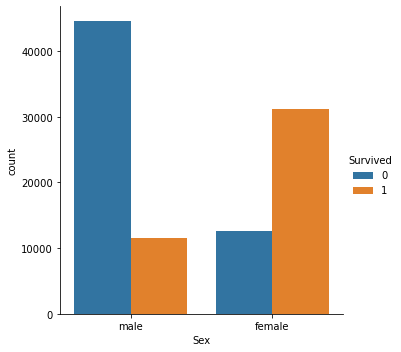

In [27]:
## your code
data_eda = data.copy()
data_sex_drop_na = data_eda.copy().dropna(subset=['Sex'])
sex = data_sex_drop_na.value_counts('Sex')
print("Количество женщин\мужчин:")
print(sex)
data_survived_drop_na = data_eda.copy().dropna(subset=['Survived'])
survived = data_survived_drop_na.value_counts('Survived')
print("Количество Живых\мертвых:")
print(survived)
sns.catplot(x ="Sex", hue ="Survived",kind ="count", data = data)

Мы видим, что от пола на прямую зависит выживание, т.к. женщин выжило гораздо больше.Так же видим количество мужчин\женщин(56114\43886),живых\мертвых(42774\57226) 

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

Средний возраст по выжившим: 40.55379931430776
Медианный возраст по выжившим: 43.0
Средний возраст по умершим: 36.708694881533724
Медианный возраст по умершим: 36.0


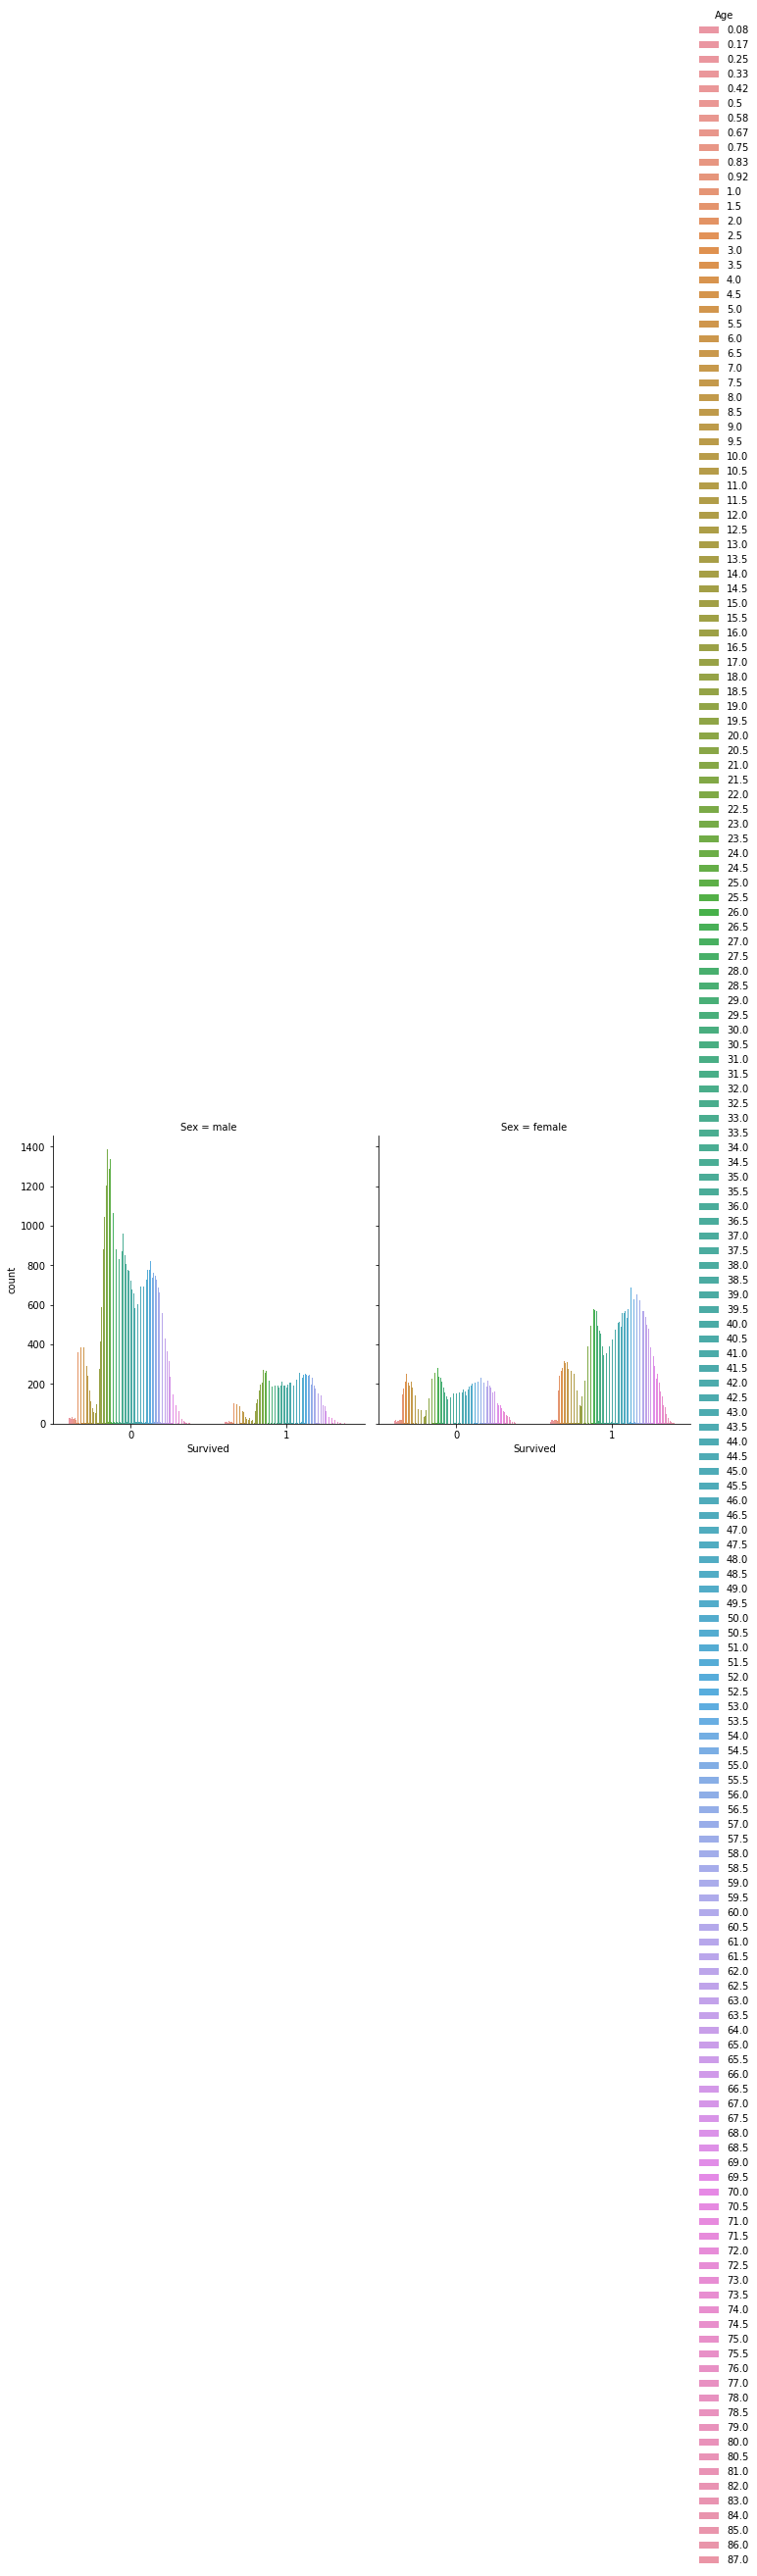

In [28]:
## your code
survived = data.loc[(data['Survived'] == 1)]
print('Средний возраст по выжившим: '+str(survived['Age'].mean()))
print('Медианный возраст по выжившим: '+str(survived['Age'].median()))
dead = data.loc[(data['Survived'] == 0)]
print('Средний возраст по умершим: '+str(dead['Age'].mean()))
print('Медианный возраст по умершим: '+str(dead['Age'].median()))
sns.catplot(x ='Survived', hue ='Age',kind ='count', col ='Sex', data = data)

Естественно возрастное распределение выживших и умерших отличается. В основном выживали либо очень молодые, либо старые. Скорее всего люди срелднего возраста помогали всем остальным и спасали в первую очередь мелких и стариков

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [ ]:
## your code
data_group_pclass_survived = data.groupby(['Pclass', 'Survived'])
pclass_survived = data_group_pclass_survived.size().unstack()
sns.heatmap(pclass_survived, annot = True, fmt ="d")
sns.catplot(x ='Embarked', hue ='Survived',kind ='count', col ='Pclass', data = data)
sns.catplot(x ='Pclass', hue ='Survived',kind ='count',  data = data)

Больше всего выжили люди в первом классе. Класс соответственно оказал прямое влияние на выживаемость. Больше всего не повезло людям, севшим на борт в "Southampton" и купившим билет третьего класса. Наибольший процент выжившиъ у людей, севших на "Cherbourg" 

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [ ]:
## your code
data_null = data.isna().sum().sort_values(ascending=False)
null_plot = data_null[data_null>0]*100
f, ax = plt.subplots(figsize=(8, 6))
sns.despine(f)
sns.barplot(null_plot.index, null_plot,)
plt.grid()
plt.title('Number of missing values in features', fontsize=16)
plt.xlabel('Missing values', fontsize=14)
plt.ylabel('Number of missing values', fontsize=14)
for i, val in enumerate(data.isna().mean().sort_values(ascending=False)*100):
    if val > 0:
        plt.text(i, null_plot.iloc[i], str(round(val,2))+'%', horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})
plt.show()

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Ну имхо я бы снес весь столбец Cabin а потом все строки, где есть Nan. Но как говорил наш коуч, "Отсутствие значений тоже может давать зависимости". Поэтомку я бы заменил все Nan значения в Cabin на определенное. И это было бы соего рода категория с неизвестной кабиной. Как в первом, так и во втором случае трудно предсказать что будет. Возможно данных не хватит из-за удаления или модель обучится неправильно из-за категории, которую я ввел. По возрасту можно было бы использовать среднее между похожими строкаами или что ин будь подобное 

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [ ]:
## your code
data_no_nan = data.copy().drop(['Cabin'], axis='columns').dropna()
data_no_nan.loc[(data_no_nan['Sex'] == 'male')] = 1
data_no_nan.loc[(data_no_nan['Sex'] == 'female')] = 0
data_x = data_no_nan.copy().drop(['Survived','Name','Ticket','Embarked'], axis='columns')
data_y = data_no_nan['Survived']

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, shuffle=True, random_state=42)
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
predictions = logisticRegr.predict(X_test)
score1 = logisticRegr.score(X_test, y_test)
print(score1)


knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train, y_train)
knn.predict_proba(X_test)
score2 = knn.score(X_test, y_test)
print(score2)

Мы имееи точность 100%. По итогу 0.23 на кагле. Похоже на переобучение. Я просто удалял все данные, которые не подходили под модель. На большее времени не хватило. Если у кого-то получилось >0.8, отпишите как, если не лень. Заранее спасибо.

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [ ]:
## your code

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [ ]:
data_test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')
data1_test_drop_na = data_test.copy().drop(['Cabin'], axis='columns').drop(['Name','Ticket','Embarked'], axis='columns')
data1_test_drop_na.loc[(data1_test_drop_na['Sex'] == 'male')] = 1
data1_test_drop_na.loc[(data1_test_drop_na['Sex'] == 'female')] = 0
predictions = logisticRegr.predict(data1_test_drop_na)

# prediction = pd.DataFrame(predictions, columns=['predictions']).to_csv('prediction.csv')
# submission = pd.DataFrame({ 'PassengerId': data1_test_drop_na.index.values.astype(int), 'Survived': predictions.astype(str) })
# submission.to_csv("my_submission.csv", index=False)